In [5]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import json

In [10]:
flex_dir = "flexibel/"
minimal_dir = "min/"
maximal_dir = "max/"

In [11]:
def string_to_list(string):
    string = string[1:-1]
    string = string.replace(" ", "")
    res = string.split(",")
    return [float(x) for x in res]    

def combine_lists(attribute_list, folder_name):
    res = []
    for file in attribute_list:
        with open(folder_name+file, "r") as infile:
            data = infile.read()
            res.append(string_to_list(data))
    return res

def mean_min_max(list_of_lists):
    _mean = []
    _min = []
    _max = []
    for elements in zip(*list_of_lists):
        _min.append(min(elements))
        _max.append(max(elements))
        _mean.append(sum(elements)/len(elements))
    return _mean, _min, _max  

In [63]:
def plot_in_between(mean_min_max_list):
    _x = list(range(len(mean_min_max_list[0])))
    _y_mean = mean_min_max_list[0]
    _y_min = mean_min_max_list[1]
    _y_max = mean_min_max_list[2]
    plt.plot(_x, _y_mean)
    plt.fill_between(_x, _y_min, _y_max, alpha=0.3)
    plt.show()

def plot_by_metric(metric):
    metric_list_flex = [path for path in os.listdir(flex_dir) if metric in path]
    metric_list_min = [path for path in os.listdir(minimal_dir) if metric in path]
    metric_list_max = [path for path in os.listdir(maximal_dir) if metric in path]
    
    _y_flex_mean, _y_flex_min, _y_flex_max = mean_min_max(combine_lists(metric_list_flex, flex_dir))
    _y_min_mean, _y_min_min, _y_min_max = mean_min_max(combine_lists(metric_list_min, minimal_dir))
    _y_max_mean, _y_max_min, _y_max_max = mean_min_max(combine_lists(metric_list_max, maximal_dir))
    _x = list(range(len(_y_flex_mean)))
    
    plt.plot(_x, _y_flex_mean, color="blue")
    plt.plot(_x, _y_min_mean, color="green")
    plt.plot(_x, _y_max_mean, color="red")
    
    plt.fill_between(_x, _y_flex_min, _y_flex_max, alpha=0.3, color="blue", label="dynamic")
    plt.fill_between(_x, _y_min_min, _y_min_max, alpha=0.3, color="green", label="min")
    plt.fill_between(_x, _y_max_min, _y_max_max, alpha=0.3, color="red", label="max")
    plt.legend(loc="best")
    plt.title(metric)
    
    plt.savefig(f"{metric}.png", dpi=400)
    plt.show()
    
    
def plot_trajectory(last_ten_trajectories):
    _x = list(range(750))
    _y_low = [12] * 750
    _y_up = [175] * 750
    for run in last_ten_trajectories:
        _xs = [0]
        _ys = [100]
        for coordinate in run[:-1]:
            _xs.append(coordinate[0])
            _ys.append(coordinate[1])
        plt.plot(_xs, _ys)
    plt.plot(_x, _y_low, color="brown")
    plt.plot(_x, _y_up, color="brown")
    plt.show()
            
            
    

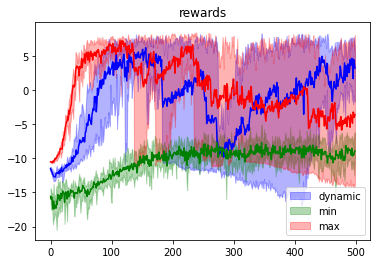

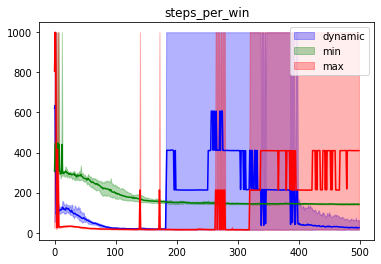

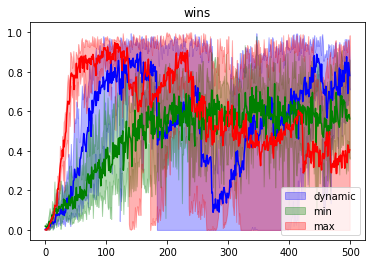

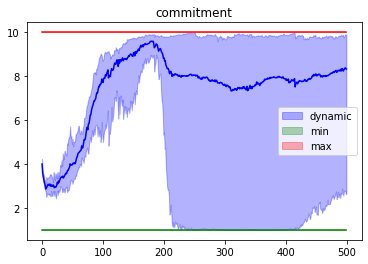

In [64]:
plot_by_metric("rewards")
plot_by_metric("steps_per_win")
plot_by_metric("wins")
plot_by_metric("commitment")

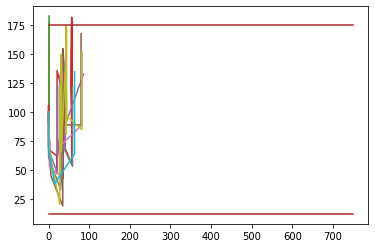

In [74]:
#flexibel
test_str="[[[32, 58], [76, 32], [125, 35], [164, 39], [212, 47], [232, 46], [282, 33], [328, 45], [373, 57], [422, 57], [468, 70], [518, 70], [563, 83], [613, 81], [0, 100]], [[38, 62], [75, 22], [79, 25], [110, 40], [160, 31], [206, 49], [211, 47], [259, 31], [303, 51], [352, 54], [400, 68], [450, 73], [499, 82], [546, 90], [596, 91], [645, 86], [0, 100]], [[38, 53], [88, 38], [137, 36], [187, 31], [230, 39], [280, 30], [318, 42], [353, 53], [402, 43], [447, 46], [487, 59], [536, 54], [571, 70], [618, 68], [0, 100]], [[35, 42], [83, 27], [130, 19], [134, 20], [159, 35], [208, 15], [244, 21], [275, 32], [300, 41], [344, 39], [386, 36], [417, 37], [459, 32], [494, 40], [533, 47], [564, 62], [600, 72], [645, 71], [0, 100]], [[43, 57], [90, 25], [135, 32], [183, 31], [215, 44], [264, 37], [309, 45], [358, 37], [398, 45], [436, 59], [481, 64], [525, 68], [569, 63], [612, 69], [0, 100]], [[32, 44], [82, 17], [121, 32], [169, 35], [217, 39], [241, 40], [288, 48], [337, 46], [387, 39], [425, 50], [469, 49], [515, 48], [549, 67], [595, 70], [642, 76], [0, 100]], [[26, 43], [76, 28], [126, 20], [155, 54], [205, 45], [230, 37], [272, 54], [287, 48], [321, 57], [370, 61], [418, 75], [467, 78], [507, 74], [557, 64], [590, 73], [636, 89], [0, 100]], [[32, 58], [75, 31], [124, 45], [173, 44], [216, 62], [265, 52], [313, 36], [350, 63], [399, 54], [449, 56], [496, 67], [544, 74], [591, 84], [641, 83], [0, 100]], [[37, 55], [81, 21], [121, 43], [171, 32], [214, 45], [263, 24], [294, 51], [343, 48], [387, 59], [435, 60], [484, 58], [532, 59], [577, 73], [624, 82], [0, 100]], [[37, 62], [81, 34], [131, 33], [179, 42], [214, 41], [264, 37], [303, 64], [349, 39], [385, 67], [435, 54], [482, 60], [526, 59], [573, 68], [602, 71], [643, 90], [0, 100]]]"
test_str="[[[24, 67], [65, 47], [115, 67], [158, 50], [206, 66], [255, 56], [302, 41], [351, 49], [400, 60], [447, 48], [489, 85], [538, 87], [587, 91], [637, 96], [0, 100]], [[21, 69], [64, 59], [114, 73], [163, 81], [204, 71], [230, 59], [275, 53], [323, 55], [373, 71], [417, 58], [466, 59], [516, 67], [566, 81], [610, 76], [0, 100]], [[36, 83], [76, 71], [119, 67], [167, 67], [212, 58], [260, 50], [310, 64], [353, 47], [402, 62], [452, 63], [502, 62], [552, 70], [598, 88], [648, 84], [0, 100]], [[31, 55], [78, 29], [124, 37], [168, 50], [218, 49], [267, 33], [315, 37], [360, 53], [409, 36], [424, 75], [472, 49], [508, 72], [557, 47], [599, 59], [636, 78], [0, 100]], [[27, 42], [70, 52], [120, 35], [148, 36], [182, 42], [0, 100]], [[21, 37], [70, 26], [115, 20], [157, 34], [201, 31], [247, 32], [297, 16], [314, 45], [355, 51], [405, 37], [447, 44], [490, 48], [539, 32], [568, 48], [606, 56], [647, 63], [0, 100]], [[18, 38], [64, 43], [88, 44], [138, 30], [188, 26], [234, 34], [280, 50], [329, 58], [379, 57], [429, 61], [478, 78], [528, 78], [569, 57], [609, 95], [0, 100]], [[37, 79], [71, 62], [120, 79], [156, 71], [195, 68], [239, 72], [279, 79], [323, 92], [348, 86], [389, 95], [429, 108], [470, 122], [505, 129], [543, 143], [583, 159], [625, 179], [0, 100]], [[23, 104], [55, 112], [95, 129], [122, 142], [154, 158], [191, 178], [0, 100]], [[30, 107], [56, 107], [91, 111], [123, 116], [154, 114], [188, 116], [233, 133], [271, 136], [305, 134], [338, 133], [373, 135], [415, 147], [455, 157], [491, 160], [529, 168], [571, 176], [610, 181], [650, 186], [0, 100]]]"
test_str="[[[42, 70], [80, 33], [127, 46], [173, 62], [222, 46], [270, 52], [318, 56], [366, 68], [406, 68], [454, 84], [492, 57], [538, 78], [588, 88], [638, 93], [0, 100]], [[41, 75], [87, 57], [136, 51], [186, 50], [236, 44], [276, 38], [324, 44], [366, 65], [414, 74], [464, 79], [514, 89], [564, 99], [614, 117], [648, 100], [0, 100]], [[38, 85], [67, 64], [113, 66], [160, 75], [210, 94], [232, 82], [271, 70], [320, 79], [363, 76], [408, 76], [456, 88], [499, 85], [548, 110], [596, 113], [604, 112], [637, 108], [0, 100]], [[47, 114], [79, 104], [103, 92], [128, 81], [153, 70], [200, 87], [235, 82], [269, 79], [307, 76], [342, 74], [391, 92], [425, 90], [472, 97], [513, 96], [551, 86], [601, 102], [649, 107], [0, 100]], [[46, 98], [72, 74], [102, 58], [144, 56], [190, 57], [225, 54], [275, 73], [316, 66], [360, 77], [409, 88], [444, 83], [486, 72], [529, 111], [566, 91], [615, 97], [0, 100]], [[47, 95], [71, 62], [111, 43], [145, 60], [195, 71], [227, 46], [272, 66], [303, 53], [343, 102], [366, 84], [396, 60], [441, 94], [469, 86], [517, 84], [567, 86], [617, 96], [0, 100]], [[42, 76], [82, 49], [132, 44], [178, 62], [220, 35], [239, 42], [286, 59], [336, 64], [386, 74], [425, 48], [466, 80], [515, 74], [564, 72], [614, 86], [0, 100]], [[44, 84], [81, 57], [131, 62], [175, 63], [220, 47], [270, 58], [315, 61], [364, 70], [414, 77], [461, 57], [509, 67], [558, 78], [607, 90], [0, 100]], [[47, 87], [81, 55], [130, 47], [176, 70], [225, 63], [270, 43], [315, 69], [365, 64], [413, 76], [463, 68], [512, 72], [558, 89], [608, 79], [0, 100]], [[47, 78], [80, 36], [122, 58], [170, 35], [211, 52], [261, 43], [307, 45], [357, 33], [401, 41], [449, 44], [490, 57], [529, 63], [571, 76], [620, 72], [0, 100]]]"
test_str="[[[0, 95], [3, 91], [4, 86], [5, 81], [7, 77], [10, 73], [10, 69], [10, 64], [10, 60], [10, 55], [11, 50], [11, 46], [12, 41], [16, 40], [19, 36], [24, 36], [29, 39], [32, 43], [37, 42], [42, 42], [47, 41], [52, 40], [60, 35], [65, 37], [69, 36], [74, 38], [79, 36], [84, 37], [89, 38], [94, 38], [99, 38], [104, 38], [109, 39], [112, 35], [129, 27], [149, 32], [165, 22], [196, 52], [200, 44], [222, 22], [265, 55], [286, 38], [318, 68], [343, 53], [382, 77], [421, 73], [461, 87], [494, 93], [521, 93], [554, 92], [593, 99], [643, 113], [0, 100]], [[1, 96], [1, 93], [1, 90], [4, 87], [5, 84], [7, 81], [7, 78], [9, 75], [9, 72], [9, 69], [9, 66], [9, 63], [9, 60], [9, 57], [9, 54], [9, 51], [9, 48], [10, 45], [13, 43], [16, 41], [21, 42], [26, 44], [31, 47], [36, 50], [40, 50], [43, 49], [48, 50], [53, 49], [57, 50], [62, 50], [66, 51], [71, 53], [76, 52], [80, 52], [84, 52], [89, 53], [94, 55], [98, 54], [102, 56], [107, 56], [110, 55], [115, 57], [120, 58], [124, 58], [126, 57], [131, 58], [135, 58], [139, 58], [142, 58], [145, 56], [148, 55], [151, 55], [154, 54], [158, 53], [161, 52], [168, 51], [190, 44], [211, 32], [260, 63], [272, 44], [316, 86], [331, 81], [346, 64], [385, 58], [420, 64], [455, 95], [467, 63], [506, 83], [546, 90], [585, 82], [623, 120], [642, 106], [0, 100]], [[0, 96], [1, 94], [1, 91], [3, 89], [7, 87], [8, 85], [8, 82], [8, 80], [8, 77], [8, 75], [10, 73], [10, 70], [10, 67], [10, 65], [10, 62], [10, 59], [10, 57], [12, 54], [12, 51], [12, 48], [14, 46], [17, 45], [22, 45], [27, 48], [31, 52], [36, 55], [41, 55], [46, 56], [53, 53], [58, 55], [63, 56], [66, 54], [70, 53], [75, 53], [79, 54], [84, 54], [89, 56], [93, 54], [97, 54], [101, 54], [106, 53], [109, 51], [114, 53], [118, 52], [120, 50], [124, 49], [129, 51], [134, 52], [139, 55], [144, 56], [148, 56], [152, 54], [161, 56], [176, 50], [191, 45], [239, 50], [275, 48], [321, 48], [366, 64], [405, 69], [442, 67], [464, 99], [475, 81], [505, 86], [554, 93], [596, 85], [640, 99], [0, 100]], [[1, 96], [5, 94], [6, 91], [7, 87], [8, 83], [8, 80], [10, 76], [10, 72], [10, 68], [10, 64], [10, 61], [10, 57], [10, 53], [10, 49], [13, 45], [15, 42], [20, 42], [25, 41], [34, 47], [38, 46], [43, 48], [48, 49], [53, 49], [58, 49], [63, 50], [68, 50], [71, 48], [76, 48], [80, 46], [85, 47], [90, 46], [94, 44], [98, 42], [103, 41], [108, 40], [116, 36], [131, 36], [156, 43], [177, 31], [227, 27], [260, 56], [0, 100]], [[3, 95], [3, 89], [6, 83], [7, 76], [7, 69], [8, 63], [8, 56], [10, 50], [10, 43], [12, 37], [16, 34], [21, 32], [25, 33], [29, 34], [39, 40], [44, 39], [49, 38], [53, 38], [58, 39], [63, 37], [67, 32], [71, 33], [76, 32], [81, 29], [86, 26], [94, 28], [123, 22], [155, 37], [183, 15], [224, 26], [258, 49], [292, 22], [322, 41], [356, 43], [391, 39], [436, 52], [483, 59], [512, 82], [552, 78], [591, 98], [641, 79], [0, 100]], [[3, 95], [5, 89], [7, 84], [7, 77], [7, 71], [7, 65], [9, 59], [9, 52], [11, 46], [14, 40], [19, 38], [23, 37], [27, 38], [32, 37], [37, 37], [42, 37], [46, 36], [51, 33], [56, 34], [59, 36], [64, 35], [69, 35], [73, 37], [76, 39], [81, 40], [85, 38], [90, 36], [95, 32], [115, 31], [134, 32], [168, 29], [194, 46], [211, 18], [251, 28], [273, 51], [315, 14], [356, 20], [403, 16], [432, 38], [457, 50], [506, 36], [539, 38], [579, 38], [598, 46], [641, 46], [684, 49], [0, 100]], [[2, 93], [6, 86], [7, 79], [7, 71], [7, 64], [8, 57], [8, 49], [8, 41], [11, 35], [16, 31], [20, 30], [23, 32], [27, 32], [32, 31], [37, 29], [41, 28], [45, 27], [50, 26], [55, 24], [57, 25], [59, 27], [64, 25], [67, 25], [72, 23], [83, 22], [91, 19], [100, 30], [104, 29], [118, 28], [0, 100]], [[0, 91], [2, 84], [4, 75], [5, 67], [8, 60], [10, 52], [10, 44], [11, 36], [16, 31], [20, 31], [24, 30], [33, 30], [37, 30], [41, 28], [46, 28], [50, 28], [55, 25], [57, 26], [61, 26], [66, 24], [69, 25], [73, 24], [85, 27], [102, 29], [122, 32], [159, 23], [201, 18], [212, 28], [230, 31], [0, 100]], [[2, 91], [3, 83], [5, 75], [9, 67], [9, 58], [9, 49], [9, 40], [9, 31], [14, 26], [19, 23], [21, 23], [23, 24], [27, 23], [31, 20], [35, 20], [36, 20], [39, 20], [42, 20], [47, 18], [61, 15], [0, 100]], [[2, 90], [4, 81], [6, 72], [7, 63], [7, 53], [7, 43], [9, 34], [14, 28], [19, 25], [24, 24], [28, 22], [32, 21], [34, 20], [35, 21], [39, 19], [42, 19], [45, 19], [49, 16], [0, 100]]]"
#min
test_str="[[[4, 98], [9, 97], [13, 95], [18, 95], [23, 94], [28, 93], [33, 91], [37, 90], [41, 88], [46, 86], [50, 84], [54, 81], [57, 77], [61, 74], [65, 71], [67, 67], [71, 63], [75, 60], [79, 58], [83, 55], [86, 52], [91, 51], [94, 47], [98, 45], [103, 43], [106, 40], [111, 38], [115, 36], [119, 34], [124, 34], [128, 32], [133, 31], [138, 31], [143, 31], [147, 31], [152, 33], [157, 31], [162, 33], [167, 34], [172, 33], [177, 34], [182, 35], [186, 34], [191, 36], [196, 38], [201, 38], [206, 40], [211, 42], [216, 42], [221, 41], [225, 43], [230, 44], [235, 45], [240, 45], [245, 47], [250, 47], [255, 47], [260, 49], [265, 51], [270, 52], [274, 50], [279, 52], [284, 52], [289, 52], [294, 53], [299, 55], [304, 55], [309, 56], [314, 57], [319, 59], [324, 59], [329, 59], [334, 60], [339, 62], [344, 63], [349, 63], [354, 63], [359, 64], [364, 65], [369, 65], [373, 65], [378, 65], [383, 66], [388, 67], [393, 69], [398, 69], [403, 71], [408, 72], [413, 73], [418, 73], [423, 75], [428, 76], [433, 78], [438, 79], [443, 80], [448, 81], [452, 81], [457, 84], [462, 85], [467, 87], [472, 89], [477, 92], [482, 93], [487, 95], [492, 97], [497, 99], [502, 101], [507, 103], [512, 105], [517, 108], [521, 109], [526, 110], [531, 112], [535, 113], [540, 115], [545, 117], [550, 120], [554, 120], [559, 124], [564, 125], [568, 126], [573, 127], [577, 127], [581, 128], [585, 128], [590, 130], [594, 130], [599, 133], [604, 134], [609, 136], [613, 136], [618, 138], [623, 139], [628, 141], [632, 141], [636, 141], [640, 141], [645, 141], [649, 141], [0, 100]], [[4, 102], [9, 102], [14, 103], [18, 103], [23, 105], [28, 105], [33, 108], [38, 109], [42, 109], [47, 112], [52, 112], [56, 113], [61, 113], [64, 112], [68, 112], [72, 110], [75, 109], [79, 109], [83, 109], [87, 108], [91, 107], [94, 106], [98, 106], [101, 104], [105, 104], [108, 103], [111, 102], [115, 101], [119, 101], [123, 100], [125, 99], [128, 97], [132, 96], [137, 97], [140, 96], [144, 95], [148, 94], [152, 92], [155, 91], [159, 89], [162, 88], [165, 86], [170, 85], [174, 85], [178, 84], [182, 83], [186, 82], [189, 80], [192, 79], [196, 78], [201, 78], [205, 77], [209, 77], [214, 78], [218, 78], [222, 77], [227, 77], [230, 76], [235, 75], [239, 75], [243, 74], [248, 74], [252, 73], [256, 73], [261, 72], [265, 72], [270, 71], [274, 71], [279, 72], [284, 72], [288, 71], [292, 70], [297, 71], [302, 71], [306, 70], [311, 70], [315, 70], [320, 71], [325, 70], [329, 70], [334, 69], [339, 71], [343, 70], [348, 71], [352, 71], [357, 73], [362, 74], [367, 76], [372, 76], [377, 76], [382, 78], [386, 79], [391, 79], [395, 79], [400, 80], [405, 80], [409, 79], [414, 80], [419, 81], [423, 83], [428, 84], [433, 86], [438, 88], [443, 90], [448, 93], [453, 94], [457, 95], [462, 96], [466, 96], [471, 98], [476, 99], [481, 100], [485, 100], [490, 102], [495, 102], [499, 103], [504, 104], [509, 105], [514, 106], [519, 108], [523, 109], [528, 109], [533, 111], [538, 113], [542, 113], [547, 112], [551, 114], [556, 114], [561, 114], [566, 116], [571, 118], [575, 118], [580, 121], [584, 121], [589, 122], [593, 121], [597, 121], [602, 122], [607, 123], [612, 126], [617, 128], [622, 129], [626, 130], [631, 130], [636, 131], [641, 132], [646, 132], [650, 132], [0, 100]], [[3, 98], [8, 98], [13, 98], [18, 98], [23, 99], [28, 100], [33, 101], [37, 101], [42, 100], [47, 100], [51, 98], [55, 97], [59, 95], [62, 93], [66, 91], [70, 90], [74, 89], [78, 88], [82, 86], [85, 83], [89, 82], [93, 80], [96, 77], [101, 76], [105, 75], [108, 72], [112, 69], [115, 66], [118, 64], [122, 62], [126, 60], [130, 58], [134, 56], [137, 53], [141, 53], [146, 52], [151, 51], [155, 51], [160, 52], [165, 52], [170, 52], [174, 51], [178, 50], [183, 49], [187, 48], [191, 46], [195, 44], [199, 43], [204, 42], [209, 41], [213, 40], [218, 40], [223, 41], [228, 42], [233, 44], [238, 45], [243, 46], [247, 46], [252, 45], [257, 45], [262, 45], [267, 46], [272, 46], [277, 48], [282, 48], [287, 49], [291, 50], [296, 51], [301, 50], [306, 52], [310, 51], [315, 54], [320, 55], [325, 56], [330, 59], [335, 60], [340, 60], [345, 62], [350, 63], [355, 65], [360, 66], [365, 66], [370, 66], [375, 68], [380, 69], [385, 70], [390, 71], [395, 73], [399, 76], [404, 77], [409, 78], [414, 81], [419, 82], [424, 84], [429, 86], [434, 88], [439, 89], [444, 90], [448, 91], [453, 93], [458, 94], [462, 94], [467, 95], [472, 97], [476, 98], [481, 99], [486, 100], [491, 101], [495, 103], [499, 103], [504, 104], [508, 103], [513, 107], [518, 108], [522, 109], [527, 110], [532, 111], [537, 111], [542, 114], [546, 114], [550, 115], [555, 115], [559, 114], [564, 116], [569, 117], [573, 119], [578, 120], [583, 121], [588, 123], [593, 124], [597, 125], [602, 127], [607, 127], [611, 128], [616, 128], [621, 129], [625, 129], [630, 129], [635, 130], [639, 131], [644, 132], [649, 133], [0, 100]], [[4, 99], [8, 100], [13, 101], [18, 101], [23, 103], [28, 105], [33, 107], [38, 108], [43, 110], [47, 110], [52, 110], [56, 110], [60, 109], [64, 109], [68, 108], [72, 108], [76, 107], [79, 105], [84, 106], [88, 104], [91, 103], [95, 102], [98, 101], [102, 100], [106, 98], [109, 96], [112, 95], [116, 94], [119, 92], [123, 91], [127, 91], [131, 90], [135, 89], [139, 89], [142, 87], [144, 85], [148, 84], [151, 83], [156, 83], [160, 83], [164, 82], [167, 79], [171, 79], [175, 78], [178, 75], [182, 75], [186, 73], [189, 72], [193, 70], [198, 71], [202, 71], [207, 71], [211, 70], [216, 70], [221, 70], [225, 70], [230, 69], [234, 69], [239, 68], [242, 66], [247, 66], [252, 67], [257, 67], [261, 66], [265, 66], [270, 65], [274, 64], [279, 65], [284, 66], [289, 66], [293, 66], [298, 67], [303, 66], [308, 66], [313, 67], [318, 68], [322, 68], [327, 67], [332, 69], [337, 70], [342, 71], [347, 72], [351, 71], [356, 70], [360, 69], [365, 70], [370, 70], [375, 71], [380, 72], [385, 73], [390, 72], [395, 72], [400, 70], [404, 68], [408, 70], [413, 71], [418, 70], [423, 69], [428, 71], [433, 73], [438, 74], [443, 75], [448, 75], [453, 75], [458, 75], [463, 74], [468, 75], [473, 76], [478, 77], [482, 76], [487, 76], [492, 77], [497, 75], [502, 77], [507, 78], [512, 79], [516, 78], [521, 79], [526, 80], [531, 82], [536, 83], [541, 84], [546, 85], [551, 85], [556, 86], [560, 88], [565, 88], [570, 89], [575, 90], [580, 90], [585, 90], [590, 90], [595, 91], [600, 92], [605, 94], [610, 94], [615, 94], [620, 96], [625, 96], [630, 98], [635, 98], [640, 98], [645, 99], [650, 99], [0, 100]], [[4, 100], [9, 99], [14, 99], [19, 100], [24, 99], [29, 98], [33, 97], [37, 95], [42, 94], [46, 92], [50, 90], [54, 89], [58, 87], [62, 85], [67, 84], [70, 81], [73, 79], [77, 77], [81, 76], [84, 73], [87, 71], [90, 69], [94, 67], [97, 65], [101, 63], [104, 61], [108, 60], [112, 59], [116, 58], [120, 56], [125, 56], [129, 56], [133, 55], [137, 53], [141, 53], [146, 53], [150, 52], [155, 51], [159, 52], [164, 53], [168, 52], [173, 53], [178, 53], [183, 53], [187, 54], [191, 53], [196, 54], [200, 53], [205, 54], [210, 54], [215, 55], [219, 54], [224, 56], [228, 55], [233, 56], [238, 57], [242, 57], [247, 59], [252, 60], [257, 61], [261, 60], [266, 61], [270, 61], [275, 60], [278, 59], [283, 60], [288, 61], [293, 62], [298, 64], [302, 63], [307, 63], [312, 64], [316, 64], [321, 67], [326, 68], [331, 68], [335, 67], [339, 68], [344, 69], [349, 71], [354, 71], [359, 73], [364, 75], [369, 76], [374, 79], [378, 80], [383, 82], [388, 83], [393, 85], [398, 86], [403, 89], [408, 90], [412, 90], [416, 89], [421, 90], [425, 90], [430, 92], [435, 93], [440, 92], [443, 91], [448, 92], [453, 93], [457, 93], [462, 93], [467, 94], [472, 95], [475, 94], [480, 95], [485, 97], [490, 98], [495, 100], [500, 100], [505, 102], [509, 102], [514, 104], [519, 106], [524, 108], [529, 109], [533, 108], [538, 110], [543, 112], [547, 112], [552, 113], [557, 115], [562, 116], [567, 117], [571, 118], [576, 119], [581, 120], [586, 122], [591, 123], [596, 125], [601, 127], [606, 129], [611, 132], [615, 131], [619, 132], [624, 133], [629, 133], [634, 134], [639, 137], [643, 137], [648, 139], [0, 100]], [[4, 101], [9, 102], [14, 104], [19, 105], [24, 107], [29, 108], [33, 108], [38, 109], [43, 111], [48, 112], [52, 112], [56, 111], [60, 112], [64, 111], [67, 110], [72, 110], [75, 108], [79, 107], [83, 107], [87, 106], [89, 104], [93, 104], [95, 101], [99, 100], [102, 98], [105, 97], [110, 96], [113, 95], [117, 94], [121, 92], [125, 91], [129, 90], [133, 89], [136, 87], [140, 85], [142, 82], [146, 81], [149, 79], [152, 77], [156, 75], [161, 76], [165, 75], [169, 74], [173, 72], [177, 70], [179, 68], [184, 67], [187, 66], [192, 66], [197, 67], [202, 67], [206, 66], [210, 65], [215, 65], [220, 65], [225, 65], [229, 64], [233, 63], [237, 62], [242, 61], [247, 61], [250, 58], [254, 58], [259, 58], [263, 57], [268, 57], [273, 57], [278, 58], [283, 59], [287, 60], [292, 59], [297, 60], [301, 61], [306, 62], [311, 63], [316, 63], [321, 65], [326, 66], [331, 68], [336, 69], [341, 71], [346, 72], [351, 72], [356, 74], [360, 74], [365, 75], [369, 75], [374, 76], [379, 76], [384, 78], [389, 78], [393, 77], [398, 79], [403, 81], [408, 83], [413, 84], [418, 85], [423, 85], [427, 85], [432, 85], [437, 87], [442, 89], [447, 90], [452, 92], [457, 94], [462, 95], [466, 95], [471, 97], [475, 98], [480, 99], [485, 103], [490, 107], [494, 107], [499, 109], [503, 110], [507, 111], [512, 113], [517, 115], [522, 117], [527, 118], [531, 119], [536, 122], [541, 124], [546, 126], [551, 128], [555, 130], [560, 133], [565, 135], [569, 137], [574, 138], [578, 140], [582, 141], [587, 143], [592, 146], [597, 148], [601, 150], [605, 151], [609, 152], [613, 153], [618, 156], [623, 157], [627, 159], [631, 160], [635, 161], [639, 163], [643, 165], [647, 166], [651, 167], [656, 169], [661, 173], [666, 175], [670, 178], [674, 180], [679, 182], [683, 183], [687, 185], [0, 100]], [[4, 103], [9, 106], [14, 110], [19, 113], [24, 117], [28, 119], [33, 123], [38, 126], [43, 129], [48, 133], [53, 136], [57, 139], [62, 142], [66, 144], [70, 144], [74, 146], [78, 147], [82, 148], [85, 149], [89, 150], [92, 150], [96, 152], [101, 154], [105, 155], [108, 156], [112, 157], [117, 160], [120, 160], [124, 162], [127, 162], [131, 163], [135, 164], [137, 164], [141, 164], [144, 165], [148, 165], [152, 166], [156, 167], [160, 169], [164, 170], [167, 171], [169, 170], [173, 171], [177, 172], [180, 172], [184, 173], [187, 173], [191, 174], [195, 175], [198, 175], [202, 175], [206, 176], [209, 175], [211, 175], [215, 175], [218, 175], [222, 175], [225, 176], [228, 175], [231, 175], [234, 174], [238, 175], [241, 175], [244, 175], [249, 176], [252, 176], [256, 176], [260, 177], [263, 176], [267, 176], [270, 176], [273, 175], [276, 174], [280, 175], [283, 174], [286, 174], [290, 175], [294, 176], [297, 176], [300, 176], [304, 176], [307, 177], [312, 179], [315, 179], [317, 178], [319, 178], [324, 179], [327, 180], [331, 181], [336, 182], [340, 183], [344, 185], [348, 186], [0, 100]], [[4, 102], [8, 102], [13, 105], [18, 108], [22, 110], [27, 112], [31, 114], [36, 117], [41, 119], [45, 121], [50, 124], [55, 126], [59, 127], [63, 130], [67, 131], [72, 133], [76, 134], [79, 134], [82, 135], [86, 137], [91, 139], [94, 140], [98, 143], [102, 144], [106, 146], [109, 147], [114, 149], [118, 152], [121, 152], [125, 154], [127, 155], [132, 157], [136, 158], [139, 160], [143, 161], [147, 163], [150, 164], [154, 165], [158, 167], [162, 169], [166, 171], [168, 172], [172, 174], [176, 175], [179, 176], [182, 177], [186, 179], [190, 180], [194, 183], [198, 184], [202, 185], [205, 186], [207, 186], [0, 100]], [[4, 101], [8, 103], [13, 106], [17, 110], [22, 112], [27, 116], [32, 119], [37, 122], [42, 126], [47, 129], [51, 130], [55, 133], [59, 133], [63, 135], [67, 136], [72, 140], [77, 143], [81, 145], [84, 146], [88, 146], [92, 148], [95, 148], [98, 149], [103, 151], [106, 152], [110, 153], [114, 154], [117, 155], [122, 157], [124, 157], [128, 157], [131, 158], [134, 158], [138, 159], [142, 160], [146, 161], [150, 162], [154, 163], [157, 163], [161, 164], [164, 164], [166, 163], [170, 164], [173, 163], [178, 165], [181, 165], [183, 164], [187, 164], [190, 163], [195, 163], [198, 163], [201, 163], [206, 164], [208, 163], [211, 162], [216, 163], [219, 162], [223, 162], [227, 163], [230, 163], [233, 162], [237, 163], [242, 164], [245, 164], [249, 164], [253, 164], [255, 164], [259, 164], [263, 164], [267, 165], [270, 165], [274, 165], [277, 166], [281, 166], [284, 166], [288, 166], [292, 167], [295, 166], [299, 167], [303, 167], [307, 167], [311, 168], [314, 168], [318, 169], [323, 171], [327, 171], [331, 172], [334, 173], [338, 174], [342, 174], [346, 175], [349, 175], [354, 176], [356, 175], [359, 175], [363, 176], [367, 176], [370, 176], [374, 176], [378, 178], [382, 179], [385, 179], [389, 179], [393, 181], [398, 182], [402, 184], [406, 185], [409, 185], [413, 186], [0, 100]], [[4, 103], [9, 104], [14, 106], [18, 109], [23, 111], [27, 112], [32, 113], [37, 116], [42, 118], [47, 120], [51, 121], [54, 120], [58, 121], [63, 122], [66, 121], [70, 121], [74, 121], [78, 121], [82, 121], [87, 122], [91, 123], [95, 123], [100, 124], [103, 123], [106, 123], [110, 123], [113, 123], [117, 123], [120, 122], [123, 122], [127, 122], [130, 121], [133, 121], [136, 120], [139, 119], [143, 119], [148, 120], [151, 119], [154, 117], [158, 117], [162, 116], [165, 115], [169, 113], [172, 112], [175, 111], [180, 111], [183, 109], [187, 109], [190, 107], [193, 106], [196, 104], [199, 102], [203, 101], [206, 100], [210, 99], [214, 98], [217, 97], [221, 97], [226, 97], [230, 97], [234, 97], [239, 97], [243, 96], [246, 95], [250, 95], [254, 93], [258, 93], [261, 92], [265, 91], [270, 91], [274, 91], [278, 91], [283, 91], [287, 91], [291, 91], [296, 91], [299, 90], [304, 90], [309, 90], [313, 90], [318, 90], [322, 90], [326, 90], [331, 90], [336, 91], [340, 91], [345, 91], [349, 89], [353, 89], [358, 89], [363, 89], [368, 90], [372, 90], [377, 90], [381, 89], [386, 89], [391, 90], [395, 89], [400, 89], [405, 90], [410, 91], [414, 90], [419, 90], [424, 90], [428, 89], [433, 89], [437, 89], [441, 87], [446, 90], [451, 91], [456, 92], [460, 92], [465, 92], [470, 93], [475, 93], [479, 92], [484, 92], [489, 94], [493, 93], [498, 94], [503, 94], [508, 96], [513, 97], [518, 99], [523, 99], [528, 100], [533, 101], [538, 102], [543, 103], [548, 103], [552, 103], [557, 105], [562, 107], [567, 109], [571, 107], [576, 108], [581, 109], [586, 111], [591, 111], [595, 110], [600, 111], [605, 112], [610, 114], [615, 114], [620, 114], [625, 115], [630, 115], [634, 114], [639, 115], [644, 115], [649, 116], [0, 100]]]"
test_str="[[[4, 101], [9, 102], [14, 103], [19, 104], [24, 106], [28, 107], [33, 109], [37, 108], [42, 108], [46, 107], [50, 107], [54, 107], [58, 106], [63, 106], [67, 106], [72, 106], [76, 106], [81, 106], [84, 105], [89, 106], [93, 106], [98, 107], [103, 107], [107, 106], [111, 106], [115, 105], [119, 104], [123, 105], [127, 104], [131, 103], [136, 103], [139, 102], [144, 101], [148, 101], [152, 99], [155, 98], [160, 98], [164, 97], [168, 96], [172, 95], [176, 95], [181, 95], [184, 94], [189, 95], [193, 94], [197, 94], [202, 94], [205, 93], [209, 92], [213, 91], [218, 91], [222, 91], [227, 91], [231, 90], [235, 90], [239, 90], [244, 90], [248, 89], [253, 89], [256, 88], [260, 87], [264, 86], [268, 85], [273, 85], [277, 84], [282, 84], [287, 84], [291, 85], [296, 85], [301, 85], [305, 84], [310, 86], [315, 86], [320, 86], [325, 88], [329, 87], [334, 88], [338, 88], [343, 88], [348, 89], [352, 88], [357, 88], [362, 89], [366, 89], [371, 89], [376, 89], [380, 90], [385, 90], [389, 89], [394, 90], [399, 90], [403, 91], [408, 92], [413, 92], [418, 94], [423, 94], [427, 94], [432, 94], [437, 95], [442, 96], [446, 96], [451, 98], [456, 98], [461, 99], [466, 101], [470, 102], [475, 104], [480, 105], [485, 106], [490, 108], [495, 110], [500, 110], [504, 112], [509, 113], [514, 113], [518, 114], [523, 115], [528, 115], [533, 116], [537, 117], [542, 117], [547, 119], [551, 119], [556, 120], [561, 123], [566, 124], [571, 125], [576, 126], [580, 128], [585, 128], [589, 128], [594, 129], [599, 131], [604, 133], [609, 133], [613, 134], [617, 134], [622, 134], [627, 135], [632, 136], [637, 138], [641, 140], [646, 141], [0, 100]], [[4, 100], [9, 101], [14, 103], [18, 103], [23, 106], [28, 108], [33, 110], [37, 110], [41, 110], [46, 110], [50, 111], [54, 111], [59, 112], [64, 113], [68, 113], [71, 113], [75, 113], [80, 113], [84, 113], [88, 113], [92, 113], [97, 114], [101, 114], [106, 115], [110, 115], [114, 115], [118, 115], [123, 116], [127, 116], [132, 118], [136, 118], [140, 119], [144, 119], [148, 119], [153, 120], [157, 120], [161, 120], [165, 121], [169, 120], [174, 121], [178, 121], [182, 122], [186, 122], [190, 121], [193, 120], [198, 121], [202, 120], [206, 120], [209, 118], [212, 117], [216, 117], [220, 116], [223, 115], [227, 114], [231, 113], [235, 112], [238, 111], [242, 110], [246, 110], [251, 111], [255, 110], [259, 108], [263, 108], [267, 107], [271, 107], [275, 106], [280, 107], [285, 106], [289, 106], [294, 106], [298, 106], [303, 105], [306, 103], [310, 102], [314, 101], [319, 101], [322, 99], [327, 100], [331, 98], [336, 98], [340, 98], [345, 99], [350, 99], [354, 98], [359, 98], [363, 98], [368, 98], [373, 98], [378, 99], [383, 100], [387, 99], [391, 98], [396, 98], [401, 99], [405, 98], [410, 98], [414, 97], [418, 96], [423, 96], [427, 96], [432, 95], [437, 96], [441, 95], [446, 95], [451, 95], [456, 97], [461, 98], [466, 99], [471, 100], [476, 102], [480, 103], [485, 105], [490, 105], [495, 107], [500, 107], [504, 107], [509, 108], [514, 109], [518, 110], [523, 112], [528, 113], [533, 113], [537, 113], [542, 115], [547, 117], [552, 118], [557, 119], [562, 121], [567, 123], [572, 124], [577, 125], [581, 126], [586, 126], [590, 125], [595, 126], [600, 127], [605, 127], [610, 128], [614, 127], [619, 129], [624, 129], [629, 130], [634, 130], [639, 131], [644, 131], [648, 131], [0, 100]], [[4, 99], [9, 98], [13, 96], [18, 96], [22, 94], [26, 93], [31, 93], [36, 92], [40, 91], [44, 90], [48, 88], [52, 86], [56, 85], [61, 85], [65, 83], [69, 82], [73, 81], [78, 80], [83, 80], [87, 78], [91, 76], [95, 74], [98, 72], [102, 70], [106, 69], [111, 67], [114, 65], [118, 63], [123, 62], [127, 61], [131, 59], [136, 59], [140, 58], [144, 56], [149, 55], [153, 54], [158, 54], [162, 51], [166, 51], [171, 50], [176, 51], [181, 51], [185, 52], [190, 52], [195, 52], [200, 51], [204, 51], [209, 51], [214, 51], [219, 51], [224, 52], [228, 51], [233, 52], [238, 52], [243, 53], [248, 54], [253, 55], [257, 55], [262, 55], [267, 57], [272, 58], [277, 59], [282, 59], [287, 60], [291, 61], [296, 61], [301, 62], [306, 63], [311, 64], [316, 64], [321, 64], [326, 65], [331, 65], [336, 66], [341, 66], [346, 67], [351, 67], [356, 67], [360, 66], [365, 66], [370, 66], [375, 66], [380, 66], [385, 66], [390, 65], [395, 65], [400, 65], [405, 65], [410, 64], [415, 64], [420, 64], [425, 64], [430, 64], [435, 64], [439, 66], [444, 66], [449, 65], [454, 68], [459, 69], [464, 69], [468, 69], [473, 69], [478, 71], [483, 71], [488, 71], [493, 70], [498, 73], [503, 74], [507, 75], [512, 76], [517, 75], [522, 75], [527, 75], [532, 76], [537, 76], [542, 77], [547, 79], [552, 80], [557, 80], [562, 82], [567, 82], [572, 82], [577, 82], [582, 83], [587, 83], [592, 85], [597, 87], [601, 87], [606, 89], [611, 90], [616, 90], [621, 91], [626, 92], [631, 93], [636, 93], [641, 95], [646, 96], [0, 100]], [[4, 98], [9, 97], [13, 95], [18, 94], [23, 95], [28, 94], [32, 93], [37, 91], [41, 89], [45, 86], [49, 85], [53, 83], [58, 81], [62, 79], [66, 78], [71, 76], [75, 74], [79, 72], [84, 71], [88, 68], [93, 68], [97, 65], [102, 65], [106, 62], [110, 60], [114, 58], [118, 54], [122, 51], [126, 49], [130, 46], [135, 44], [139, 41], [144, 40], [149, 39], [154, 39], [159, 37], [164, 37], [169, 36], [174, 34], [179, 35], [184, 34], [189, 34], [193, 36], [198, 36], [203, 35], [208, 35], [213, 35], [218, 35], [223, 36], [228, 36], [233, 37], [238, 37], [243, 38], [248, 40], [253, 39], [258, 39], [263, 39], [268, 40], [272, 41], [277, 43], [282, 43], [287, 44], [292, 44], [297, 44], [302, 46], [307, 48], [312, 48], [317, 48], [322, 49], [327, 49], [332, 51], [337, 53], [341, 54], [346, 56], [351, 56], [356, 56], [361, 56], [366, 57], [371, 57], [376, 57], [381, 58], [386, 59], [391, 60], [396, 60], [401, 62], [406, 63], [411, 63], [416, 65], [421, 65], [425, 65], [430, 65], [435, 66], [440, 67], [445, 69], [450, 69], [455, 70], [460, 71], [465, 71], [470, 73], [475, 74], [480, 75], [484, 74], [489, 75], [494, 74], [499, 75], [504, 75], [509, 77], [514, 78], [519, 79], [524, 80], [529, 81], [534, 83], [539, 84], [544, 83], [549, 84], [554, 84], [559, 84], [564, 84], [568, 83], [573, 84], [578, 84], [583, 84], [588, 86], [593, 86], [598, 86], [603, 87], [608, 87], [613, 88], [618, 89], [623, 89], [628, 90], [633, 91], [638, 91], [643, 91], [648, 93], [0, 100]], [[4, 99], [9, 98], [14, 97], [19, 96], [24, 95], [29, 94], [33, 92], [37, 89], [42, 87], [46, 85], [50, 82], [55, 80], [59, 77], [63, 74], [68, 72], [73, 71], [77, 69], [82, 66], [85, 63], [90, 60], [94, 57], [98, 54], [102, 52], [106, 50], [111, 47], [115, 46], [120, 44], [124, 41], [128, 39], [133, 37], [138, 36], [143, 36], [147, 35], [152, 33], [157, 33], [162, 32], [167, 34], [172, 33], [177, 33], [182, 34], [186, 34], [191, 34], [196, 34], [201, 34], [206, 34], [211, 34], [216, 35], [221, 35], [226, 35], [231, 36], [236, 37], [241, 38], [246, 38], [251, 38], [256, 39], [261, 38], [266, 40], [270, 41], [275, 42], [280, 40], [285, 40], [290, 40], [295, 41], [299, 42], [304, 43], [309, 44], [314, 44], [319, 43], [323, 44], [328, 43], [333, 44], [337, 45], [342, 45], [347, 44], [352, 44], [357, 44], [362, 43], [366, 45], [371, 44], [376, 44], [381, 44], [386, 44], [390, 45], [395, 46], [399, 48], [403, 49], [408, 50], [413, 51], [418, 51], [422, 52], [427, 51], [431, 52], [436, 53], [441, 53], [446, 51], [451, 50], [455, 51], [459, 52], [464, 51], [469, 51], [474, 50], [478, 50], [483, 49], [488, 49], [493, 49], [498, 49], [502, 49], [507, 49], [512, 50], [516, 51], [521, 52], [525, 54], [529, 55], [534, 56], [537, 58], [542, 60], [546, 61], [551, 62], [555, 63], [560, 63], [565, 63], [570, 64], [575, 65], [580, 67], [584, 68], [589, 68], [594, 69], [599, 69], [604, 71], [608, 73], [613, 74], [618, 75], [623, 77], [628, 78], [632, 80], [637, 82], [642, 82], [646, 85], [0, 100]], [[4, 99], [9, 98], [14, 98], [19, 95], [23, 93], [28, 92], [33, 91], [37, 89], [42, 86], [46, 84], [51, 82], [55, 79], [59, 76], [63, 73], [67, 70], [71, 67], [75, 63], [79, 59], [84, 57], [88, 54], [92, 51], [97, 48], [101, 45], [106, 44], [111, 41], [115, 38], [119, 34], [124, 33], [129, 30], [134, 29], [139, 28], [143, 28], [148, 28], [153, 27], [158, 26], [163, 27], [168, 27], [173, 28], [177, 30], [182, 30], [187, 29], [192, 30], [197, 31], [202, 31], [207, 33], [212, 32], [216, 33], [221, 33], [226, 33], [231, 35], [236, 35], [241, 36], [245, 36], [250, 37], [255, 38], [260, 39], [265, 39], [270, 39], [275, 38], [279, 39], [284, 40], [289, 41], [293, 41], [298, 41], [303, 42], [308, 42], [313, 42], [318, 42], [323, 41], [328, 41], [333, 41], [337, 42], [342, 42], [347, 43], [352, 43], [356, 43], [361, 44], [366, 45], [370, 46], [375, 47], [380, 48], [385, 48], [390, 49], [394, 50], [399, 51], [404, 51], [409, 52], [414, 52], [418, 52], [423, 53], [428, 54], [433, 55], [438, 56], [442, 57], [447, 57], [452, 58], [457, 58], [462, 59], [467, 60], [472, 60], [476, 60], [481, 59], [486, 60], [491, 60], [496, 60], [501, 59], [506, 59], [511, 58], [516, 57], [521, 57], [526, 56], [531, 57], [536, 56], [540, 56], [545, 56], [550, 56], [553, 58], [558, 58], [563, 59], [567, 59], [571, 61], [576, 61], [581, 61], [585, 62], [590, 63], [594, 63], [599, 64], [603, 66], [608, 66], [613, 67], [617, 68], [622, 69], [626, 71], [631, 70], [636, 71], [641, 71], [646, 71], [650, 73], [0, 100]], [[4, 97], [8, 93], [13, 92], [18, 89], [23, 86], [27, 83], [32, 82], [36, 78], [40, 74], [45, 71], [49, 68], [53, 64], [57, 60], [62, 57], [65, 53], [69, 49], [73, 45], [78, 43], [82, 40], [86, 35], [89, 31], [94, 27], [99, 25], [104, 23], [109, 22], [114, 21], [118, 21], [123, 21], [128, 23], [133, 22], [137, 24], [142, 23], [147, 24], [151, 25], [156, 26], [161, 25], [166, 25], [171, 25], [174, 28], [179, 27], [184, 27], [189, 28], [194, 28], [199, 28], [203, 28], [208, 28], [213, 29], [218, 30], [222, 31], [227, 32], [231, 33], [236, 34], [241, 35], [246, 34], [250, 35], [255, 36], [260, 37], [264, 38], [269, 39], [274, 38], [278, 40], [283, 40], [288, 41], [293, 42], [298, 42], [303, 43], [307, 45], [312, 44], [317, 45], [322, 45], [327, 45], [331, 46], [336, 47], [341, 47], [346, 47], [351, 46], [356, 47], [361, 47], [366, 48], [371, 50], [375, 51], [380, 51], [385, 53], [390, 53], [394, 55], [399, 56], [404, 57], [409, 57], [414, 58], [419, 59], [424, 59], [429, 59], [434, 60], [438, 62], [443, 61], [448, 62], [453, 63], [458, 65], [463, 65], [468, 65], [473, 66], [478, 66], [483, 66], [487, 68], [492, 69], [497, 69], [502, 70], [507, 70], [512, 70], [517, 70], [522, 72], [526, 73], [531, 74], [536, 74], [541, 75], [546, 75], [551, 75], [556, 75], [561, 75], [566, 76], [571, 77], [576, 76], [581, 76], [586, 77], [591, 78], [596, 79], [601, 81], [606, 82], [611, 82], [615, 83], [620, 84], [625, 85], [630, 85], [635, 87], [640, 88], [645, 88], [650, 89], [0, 100]], [[4, 100], [9, 99], [14, 98], [19, 96], [24, 95], [28, 93], [33, 91], [38, 89], [42, 87], [46, 84], [50, 82], [55, 80], [60, 78], [64, 76], [69, 74], [74, 72], [78, 70], [82, 67], [86, 63], [91, 61], [95, 59], [99, 55], [103, 52], [107, 50], [111, 47], [116, 43], [120, 40], [124, 38], [129, 36], [134, 35], [139, 33], [143, 31], [148, 31], [153, 31], [158, 31], [163, 30], [168, 30], [173, 31], [178, 31], [183, 31], [188, 31], [193, 31], [198, 30], [202, 32], [207, 33], [212, 34], [217, 36], [222, 36], [227, 36], [232, 36], [237, 36], [242, 36], [247, 37], [252, 37], [256, 38], [261, 40], [266, 39], [271, 41], [276, 41], [281, 43], [286, 44], [291, 43], [295, 45], [300, 45], [305, 45], [310, 45], [315, 47], [320, 48], [324, 46], [329, 46], [334, 47], [339, 46], [344, 47], [349, 47], [354, 48], [359, 49], [364, 50], [368, 52], [373, 52], [378, 53], [383, 53], [388, 54], [393, 55], [398, 56], [403, 55], [408, 56], [413, 57], [418, 57], [423, 58], [428, 60], [433, 60], [437, 61], [442, 61], [447, 61], [452, 62], [457, 63], [462, 64], [467, 64], [472, 65], [477, 66], [481, 67], [486, 68], [491, 69], [496, 69], [501, 69], [506, 70], [510, 70], [515, 69], [520, 70], [525, 70], [530, 70], [535, 71], [540, 71], [545, 71], [550, 71], [555, 71], [560, 71], [564, 72], [569, 73], [574, 73], [579, 72], [584, 72], [589, 73], [594, 73], [599, 74], [603, 75], [608, 76], [613, 76], [618, 75], [623, 75], [628, 75], [633, 75], [637, 75], [642, 74], [647, 73], [0, 100]], [[4, 97], [9, 93], [14, 91], [19, 90], [23, 87], [28, 85], [33, 84], [38, 81], [41, 77], [46, 73], [51, 71], [55, 68], [60, 65], [64, 61], [69, 59], [73, 54], [77, 52], [81, 48], [85, 44], [89, 42], [93, 38], [97, 35], [102, 32], [106, 30], [111, 29], [116, 27], [121, 26], [126, 25], [131, 24], [136, 24], [141, 24], [146, 24], [150, 26], [155, 27], [160, 26], [165, 26], [170, 27], [175, 28], [179, 29], [183, 31], [188, 31], [193, 30], [198, 32], [203, 32], [208, 32], [213, 33], [217, 35], [222, 34], [227, 34], [232, 36], [237, 37], [242, 37], [247, 38], [251, 36], [256, 35], [261, 37], [265, 40], [270, 41], [275, 41], [280, 41], [285, 42], [290, 43], [294, 41], [299, 43], [304, 43], [309, 44], [313, 44], [318, 46], [323, 45], [328, 46], [333, 46], [337, 44], [342, 44], [347, 45], [352, 47], [357, 47], [361, 48], [366, 50], [371, 51], [376, 52], [380, 51], [385, 52], [390, 54], [395, 55], [400, 55], [405, 55], [410, 55], [414, 56], [419, 57], [424, 58], [429, 59], [434, 60], [439, 59], [444, 61], [449, 62], [454, 63], [459, 64], [463, 66], [468, 66], [473, 68], [478, 68], [483, 69], [488, 71], [493, 72], [498, 73], [503, 73], [508, 74], [513, 76], [518, 77], [523, 78], [528, 79], [533, 80], [538, 82], [542, 83], [547, 84], [552, 83], [557, 84], [562, 85], [567, 86], [572, 87], [577, 87], [582, 86], [587, 87], [591, 87], [596, 87], [601, 89], [606, 90], [611, 91], [616, 92], [621, 93], [626, 95], [631, 95], [636, 98], [641, 98], [646, 98], [0, 100]], [[4, 99], [9, 99], [14, 99], [18, 98], [23, 99], [28, 99], [32, 98], [36, 96], [41, 95], [45, 95], [50, 94], [54, 93], [59, 92], [63, 92], [68, 91], [72, 90], [77, 90], [81, 90], [85, 88], [89, 86], [93, 85], [97, 84], [101, 83], [105, 81], [109, 79], [113, 77], [116, 74], [120, 72], [124, 70], [128, 67], [131, 64], [136, 62], [140, 61], [144, 58], [148, 56], [153, 55], [157, 54], [161, 51], [166, 50], [170, 50], [175, 49], [180, 47], [185, 47], [190, 47], [194, 45], [199, 45], [204, 45], [209, 44], [213, 42], [218, 42], [223, 41], [228, 41], [233, 42], [238, 42], [243, 42], [248, 41], [253, 41], [258, 41], [263, 41], [268, 42], [273, 41], [278, 42], [283, 42], [288, 43], [293, 45], [297, 46], [302, 46], [307, 47], [312, 49], [317, 49], [322, 49], [327, 50], [332, 52], [337, 52], [341, 53], [346, 53], [351, 54], [356, 55], [361, 55], [366, 55], [371, 55], [376, 55], [381, 55], [386, 55], [391, 55], [396, 55], [401, 56], [406, 57], [411, 59], [416, 59], [420, 60], [425, 61], [430, 63], [435, 62], [440, 63], [445, 65], [450, 65], [455, 65], [460, 66], [465, 66], [470, 67], [475, 68], [480, 69], [484, 68], [489, 71], [494, 72], [499, 73], [504, 74], [509, 73], [514, 73], [519, 73], [524, 74], [528, 76], [533, 76], [538, 77], [543, 78], [548, 80], [553, 80], [558, 82], [563, 83], [568, 81], [573, 82], [577, 83], [582, 84], [587, 85], [592, 86], [597, 86], [602, 86], [607, 86], [612, 86], [617, 87], [622, 88], [627, 88], [632, 89], [637, 89], [642, 90], [647, 91], [0, 100]]]"
test_str="[[[4, 96], [9, 92], [14, 88], [19, 85], [24, 81], [28, 77], [33, 72], [37, 67], [41, 62], [46, 57], [51, 53], [56, 49], [59, 43], [63, 37], [66, 30], [69, 24], [73, 18], [78, 14], [0, 100]], [[4, 95], [9, 91], [14, 86], [19, 83], [23, 79], [28, 75], [33, 71], [37, 66], [42, 63], [47, 59], [51, 53], [56, 49], [59, 43], [63, 37], [67, 32], [71, 27], [76, 23], [80, 18], [85, 16], [90, 14], [0, 100]], [[4, 95], [9, 91], [13, 87], [18, 84], [22, 79], [27, 75], [32, 71], [36, 67], [40, 64], [45, 60], [50, 57], [55, 53], [59, 48], [63, 44], [67, 38], [71, 33], [75, 28], [79, 23], [84, 20], [89, 17], [94, 15], [99, 13], [0, 100]], [[4, 96], [9, 92], [14, 89], [19, 85], [23, 79], [28, 75], [32, 69], [36, 64], [41, 60], [46, 56], [51, 53], [55, 48], [59, 42], [63, 36], [66, 31], [69, 24], [74, 20], [78, 15], [83, 15], [88, 14], [93, 13], [97, 13], [101, 13], [105, 14], [109, 15], [113, 16], [118, 16], [123, 13], [127, 13], [0, 100]], [[4, 96], [9, 91], [14, 88], [19, 85], [24, 82], [28, 79], [32, 74], [37, 71], [42, 67], [46, 62], [51, 58], [56, 55], [60, 51], [64, 46], [67, 40], [70, 35], [74, 30], [78, 25], [82, 21], [87, 18], [92, 16], [97, 14], [102, 13], [107, 13], [111, 13], [115, 14], [120, 14], [124, 15], [128, 16], [132, 18], [136, 19], [141, 18], [145, 19], [150, 19], [154, 18], [159, 17], [164, 17], [169, 17], [174, 16], [179, 15], [183, 15], [188, 13], [192, 14], [197, 13], [0, 100]], [[4, 96], [9, 92], [14, 91], [19, 87], [23, 83], [28, 80], [33, 75], [37, 71], [41, 66], [46, 63], [51, 60], [56, 57], [60, 52], [65, 48], [68, 43], [72, 37], [76, 32], [80, 27], [84, 23], [88, 19], [93, 17], [98, 16], [103, 16], [108, 16], [113, 15], [117, 16], [121, 17], [126, 17], [130, 18], [135, 18], [140, 17], [145, 17], [149, 17], [154, 17], [159, 18], [163, 19], [168, 19], [172, 19], [177, 20], [182, 20], [185, 22], [190, 22], [195, 23], [200, 22], [205, 21], [209, 21], [214, 22], [218, 22], [223, 22], [228, 22], [233, 23], [237, 24], [242, 24], [247, 23], [252, 23], [257, 22], [261, 23], [266, 24], [271, 23], [276, 22], [281, 23], [286, 22], [291, 22], [295, 22], [300, 22], [305, 22], [310, 21], [315, 21], [319, 21], [324, 22], [329, 23], [333, 24], [338, 25], [341, 28], [345, 30], [350, 29], [355, 30], [360, 31], [364, 32], [369, 32], [374, 31], [379, 31], [384, 31], [389, 32], [394, 33], [398, 34], [403, 36], [408, 35], [413, 36], [418, 35], [422, 37], [427, 36], [432, 36], [437, 36], [442, 37], [446, 39], [451, 38], [456, 40], [461, 41], [466, 41], [470, 43], [475, 44], [480, 45], [484, 47], [489, 48], [494, 49], [499, 49], [504, 50], [509, 51], [514, 52], [518, 53], [523, 55], [528, 54], [533, 55], [538, 56], [543, 55], [547, 58], [551, 60], [556, 60], [561, 61], [566, 62], [571, 63], [575, 64], [580, 65], [585, 65], [590, 64], [595, 64], [600, 65], [604, 66], [609, 68], [614, 68], [618, 68], [623, 70], [627, 71], [632, 69], [637, 70], [642, 69], [647, 69], [0, 100]], [[4, 98], [9, 95], [14, 94], [19, 95], [24, 95], [29, 96], [33, 93], [38, 91], [42, 88], [47, 87], [52, 85], [56, 82], [61, 80], [65, 78], [70, 76], [74, 73], [77, 69], [81, 65], [85, 62], [88, 58], [92, 54], [95, 50], [100, 48], [105, 46], [109, 42], [113, 39], [117, 36], [121, 33], [125, 31], [130, 30], [135, 29], [140, 28], [145, 28], [150, 27], [155, 25], [160, 26], [165, 25], [170, 25], [175, 26], [180, 26], [184, 29], [189, 30], [194, 31], [199, 31], [204, 32], [209, 35], [214, 35], [219, 36], [224, 35], [229, 36], [234, 36], [239, 36], [243, 39], [248, 40], [253, 41], [258, 42], [263, 41], [268, 43], [273, 43], [278, 44], [283, 44], [288, 45], [293, 45], [298, 46], [303, 47], [308, 49], [312, 48], [317, 46], [322, 49], [327, 50], [332, 52], [337, 53], [342, 53], [347, 53], [351, 53], [356, 54], [361, 55], [366, 56], [371, 56], [376, 55], [381, 57], [386, 58], [391, 59], [396, 60], [401, 60], [406, 61], [411, 62], [416, 63], [421, 65], [426, 65], [430, 64], [435, 65], [440, 67], [445, 67], [450, 69], [455, 70], [460, 70], [465, 71], [470, 72], [475, 71], [480, 73], [485, 73], [490, 73], [495, 74], [500, 75], [505, 76], [509, 75], [514, 76], [519, 77], [524, 78], [529, 79], [534, 80], [539, 81], [544, 82], [549, 84], [554, 86], [559, 86], [564, 87], [569, 89], [574, 90], [579, 91], [584, 92], [589, 93], [594, 94], [599, 94], [604, 94], [609, 95], [614, 96], [618, 98], [623, 100], [628, 100], [633, 102], [638, 102], [643, 103], [648, 103], [0, 100]], [[4, 101], [9, 101], [14, 100], [18, 100], [23, 100], [28, 101], [32, 100], [37, 99], [41, 97], [44, 95], [49, 95], [54, 94], [59, 94], [63, 94], [68, 93], [72, 93], [76, 91], [80, 91], [85, 90], [89, 90], [93, 89], [97, 87], [101, 86], [104, 84], [108, 83], [111, 80], [114, 78], [118, 76], [119, 72], [123, 70], [127, 68], [130, 66], [133, 63], [137, 61], [141, 59], [144, 56], [148, 54], [150, 51], [153, 48], [156, 45], [160, 44], [163, 41], [166, 39], [171, 38], [175, 37], [180, 36], [185, 36], [190, 36], [194, 36], [199, 36], [204, 37], [209, 37], [214, 37], [219, 38], [224, 40], [229, 40], [234, 40], [238, 40], [243, 40], [248, 43], [253, 43], [258, 43], [263, 44], [268, 45], [273, 44], [278, 46], [283, 46], [288, 47], [293, 47], [298, 48], [303, 50], [308, 51], [312, 49], [317, 49], [322, 50], [326, 50], [331, 51], [336, 50], [341, 52], [346, 53], [351, 54], [356, 55], [361, 55], [366, 55], [371, 54], [376, 56], [381, 56], [385, 58], [390, 60], [395, 62], [400, 62], [405, 61], [410, 62], [415, 64], [420, 64], [425, 64], [430, 63], [435, 63], [440, 62], [445, 63], [450, 63], [454, 65], [459, 65], [464, 66], [469, 65], [474, 65], [479, 66], [484, 66], [489, 66], [494, 67], [499, 67], [504, 68], [508, 69], [513, 69], [518, 68], [523, 69], [528, 69], [533, 70], [538, 70], [543, 69], [548, 70], [552, 71], [557, 72], [562, 72], [567, 73], [572, 74], [577, 75], [581, 75], [586, 75], [591, 75], [596, 75], [601, 75], [606, 76], [611, 77], [616, 77], [621, 77], [626, 77], [630, 77], [635, 77], [639, 79], [644, 79], [649, 80], [0, 100]], [[4, 97], [9, 95], [14, 93], [19, 92], [24, 89], [27, 85], [32, 83], [37, 82], [41, 79], [46, 78], [51, 75], [55, 72], [59, 68], [63, 66], [67, 63], [72, 62], [76, 59], [80, 56], [84, 53], [89, 51], [91, 47], [94, 43], [98, 41], [102, 37], [104, 33], [108, 30], [112, 27], [117, 25], [122, 25], [126, 22], [131, 22], [136, 23], [141, 22], [146, 22], [151, 23], [156, 23], [161, 24], [165, 25], [170, 26], [175, 26], [180, 27], [185, 28], [190, 28], [195, 28], [200, 28], [205, 29], [209, 29], [214, 29], [219, 30], [224, 28], [229, 30], [234, 31], [238, 32], [243, 34], [248, 35], [253, 35], [257, 36], [262, 37], [267, 39], [272, 38], [277, 39], [282, 40], [287, 40], [292, 41], [297, 42], [301, 44], [306, 45], [311, 45], [316, 47], [321, 47], [326, 49], [331, 49], [336, 50], [341, 50], [346, 50], [351, 51], [356, 50], [361, 50], [366, 51], [371, 52], [376, 52], [381, 52], [386, 53], [390, 54], [395, 55], [400, 56], [405, 56], [410, 57], [415, 57], [420, 57], [425, 58], [430, 59], [435, 60], [440, 61], [444, 64], [449, 63], [454, 63], [459, 65], [464, 66], [469, 66], [474, 67], [479, 69], [484, 70], [488, 72], [493, 72], [498, 73], [502, 76], [507, 77], [512, 77], [517, 79], [522, 81], [527, 83], [531, 82], [536, 83], [541, 83], [546, 82], [551, 81], [556, 81], [561, 81], [566, 82], [571, 82], [576, 83], [581, 84], [586, 83], [591, 85], [596, 86], [601, 86], [606, 86], [611, 86], [616, 86], [621, 87], [626, 87], [630, 89], [635, 88], [640, 89], [645, 90], [650, 91], [0, 100]], [[4, 97], [9, 95], [14, 94], [18, 92], [23, 91], [28, 88], [33, 87], [36, 83], [41, 80], [45, 77], [50, 74], [54, 71], [58, 68], [63, 65], [66, 60], [70, 56], [74, 52], [78, 48], [81, 44], [84, 39], [87, 34], [91, 31], [95, 26], [99, 23], [104, 22], [109, 21], [114, 21], [119, 20], [124, 19], [129, 20], [134, 19], [138, 20], [143, 18], [148, 19], [152, 20], [157, 20], [162, 21], [166, 22], [171, 22], [175, 23], [179, 23], [184, 24], [189, 23], [193, 25], [198, 25], [202, 26], [206, 27], [211, 26], [216, 28], [220, 29], [225, 28], [230, 27], [234, 28], [239, 28], [244, 26], [249, 26], [254, 25], [258, 27], [263, 27], [268, 27], [272, 28], [277, 28], [281, 30], [286, 30], [291, 30], [295, 31], [300, 31], [305, 31], [309, 31], [313, 33], [318, 32], [323, 31], [328, 32], [333, 32], [338, 31], [343, 32], [347, 32], [352, 31], [357, 31], [362, 30], [367, 29], [371, 30], [376, 29], [381, 27], [386, 28], [391, 28], [396, 27], [400, 27], [405, 27], [410, 27], [415, 27], [419, 28], [423, 29], [428, 28], [433, 28], [438, 28], [442, 29], [447, 28], [452, 28], [457, 27], [462, 27], [467, 25], [472, 25], [477, 24], [481, 25], [486, 25], [491, 25], [496, 24], [500, 23], [505, 24], [510, 22], [514, 23], [518, 24], [523, 24], [528, 23], [533, 22], [538, 21], [542, 21], [547, 21], [551, 20], [556, 19], [561, 18], [565, 18], [570, 17], [575, 16], [580, 15], [584, 16], [589, 14], [594, 13], [598, 14], [603, 13], [0, 100]]]"
test_str="[[[4, 96], [9, 91], [14, 85], [18, 78], [23, 73], [27, 68], [32, 62], [36, 55], [40, 49], [42, 41], [45, 35], [48, 28], [52, 22], [57, 18], [62, 13], [0, 100]], [[4, 95], [9, 92], [14, 87], [19, 83], [24, 79], [28, 73], [32, 68], [37, 64], [41, 58], [44, 51], [47, 45], [49, 38], [52, 30], [55, 23], [60, 19], [65, 16], [70, 14], [0, 100]], [[4, 96], [9, 93], [14, 90], [19, 87], [24, 82], [28, 77], [32, 72], [36, 67], [40, 60], [43, 54], [45, 47], [49, 41], [51, 34], [55, 28], [59, 23], [63, 18], [68, 14], [0, 100]], [[4, 97], [9, 95], [14, 93], [19, 89], [23, 84], [27, 79], [32, 75], [37, 71], [41, 67], [44, 61], [47, 55], [50, 50], [53, 44], [56, 39], [59, 33], [64, 30], [69, 27], [73, 23], [78, 21], [83, 20], [87, 16], [92, 16], [97, 16], [101, 17], [105, 19], [109, 20], [113, 20], [118, 21], [122, 21], [127, 22], [132, 20], [135, 22], [140, 24], [145, 23], [150, 23], [154, 24], [159, 23], [164, 24], [168, 25], [173, 26], [177, 27], [181, 29], [186, 30], [190, 31], [195, 30], [200, 31], [204, 33], [208, 34], [213, 33], [218, 33], [223, 33], [227, 34], [232, 35], [236, 36], [240, 37], [244, 39], [249, 39], [254, 38], [258, 39], [261, 41], [266, 40], [271, 40], [276, 39], [280, 40], [284, 41], [289, 40], [293, 40], [297, 41], [301, 43], [306, 43], [310, 43], [315, 43], [319, 44], [324, 44], [329, 44], [332, 46], [336, 46], [340, 47], [344, 48], [349, 48], [353, 48], [358, 49], [362, 50], [367, 50], [371, 51], [375, 52], [380, 52], [384, 53], [389, 54], [393, 55], [397, 56], [401, 57], [406, 57], [411, 57], [415, 58], [420, 57], [424, 57], [428, 59], [433, 58], [438, 58], [443, 58], [448, 59], [452, 60], [456, 61], [461, 61], [465, 63], [469, 64], [473, 66], [477, 67], [482, 67], [487, 66], [490, 68], [495, 68], [500, 69], [504, 70], [509, 70], [513, 71], [518, 71], [522, 72], [527, 71], [532, 72], [537, 72], [541, 71], [546, 73], [550, 74], [555, 75], [560, 76], [564, 77], [569, 77], [574, 78], [579, 78], [583, 79], [588, 81], [593, 81], [597, 83], [602, 84], [606, 86], [611, 84], [616, 83], [621, 84], [626, 83], [631, 84], [635, 85], [640, 85], [645, 86], [650, 85], [0, 100]], [[4, 98], [9, 97], [14, 95], [19, 93], [24, 90], [28, 87], [32, 83], [36, 80], [40, 76], [45, 74], [48, 69], [50, 64], [53, 59], [56, 55], [59, 50], [63, 46], [66, 41], [70, 38], [75, 36], [80, 33], [84, 30], [88, 27], [93, 25], [98, 24], [103, 22], [108, 22], [113, 23], [117, 24], [122, 24], [127, 25], [132, 25], [137, 25], [142, 26], [146, 27], [151, 27], [156, 28], [160, 30], [165, 29], [170, 29], [175, 29], [179, 31], [184, 31], [189, 30], [194, 30], [199, 29], [204, 31], [208, 31], [213, 33], [217, 36], [221, 36], [226, 36], [231, 36], [235, 38], [240, 38], [245, 38], [250, 39], [254, 40], [259, 40], [264, 41], [268, 41], [273, 40], [278, 40], [282, 41], [287, 42], [292, 41], [296, 42], [300, 44], [305, 43], [310, 43], [314, 45], [318, 46], [323, 46], [328, 45], [331, 48], [335, 50], [339, 50], [344, 51], [349, 51], [353, 52], [358, 51], [362, 52], [367, 51], [372, 52], [376, 53], [381, 54], [385, 54], [389, 56], [394, 56], [399, 56], [403, 57], [408, 57], [413, 57], [418, 57], [423, 58], [427, 59], [432, 59], [437, 60], [441, 61], [444, 64], [449, 65], [454, 64], [459, 64], [464, 64], [468, 65], [472, 67], [476, 68], [481, 68], [486, 68], [491, 68], [495, 69], [500, 69], [505, 68], [510, 68], [515, 68], [520, 68], [524, 69], [529, 69], [533, 71], [537, 73], [541, 74], [546, 74], [551, 75], [555, 77], [559, 77], [564, 77], [569, 78], [573, 80], [578, 80], [582, 81], [587, 81], [592, 81], [597, 81], [601, 82], [606, 83], [610, 84], [615, 83], [619, 84], [624, 82], [629, 82], [634, 82], [638, 84], [641, 86], [646, 85], [650, 86], [0, 100]], [[4, 96], [9, 95], [14, 92], [19, 89], [24, 86], [28, 83], [33, 80], [37, 76], [40, 71], [44, 66], [47, 61], [50, 56], [54, 52], [56, 46], [60, 41], [64, 37], [67, 32], [71, 28], [76, 24], [81, 23], [85, 20], [90, 20], [95, 20], [100, 22], [104, 22], [109, 21], [114, 22], [119, 21], [124, 22], [128, 25], [133, 24], [137, 26], [142, 27], [147, 27], [152, 28], [157, 28], [161, 29], [166, 32], [171, 32], [176, 32], [181, 32], [185, 33], [190, 35], [195, 36], [200, 36], [205, 37], [210, 38], [215, 37], [219, 38], [224, 38], [229, 38], [234, 38], [239, 38], [244, 40], [249, 41], [253, 42], [258, 44], [263, 43], [268, 43], [273, 42], [278, 42], [283, 42], [288, 42], [292, 44], [297, 45], [302, 44], [306, 46], [311, 47], [316, 46], [321, 46], [326, 47], [331, 48], [335, 48], [340, 50], [345, 51], [349, 52], [354, 52], [359, 54], [364, 54], [368, 56], [373, 57], [377, 58], [382, 58], [387, 59], [392, 57], [396, 59], [401, 58], [406, 60], [411, 58], [415, 60], [420, 60], [425, 61], [430, 61], [434, 63], [439, 64], [444, 64], [449, 64], [453, 65], [458, 65], [463, 65], [467, 67], [472, 66], [477, 65], [482, 65], [485, 68], [490, 69], [495, 69], [500, 69], [505, 69], [510, 69], [514, 71], [519, 72], [524, 72], [528, 73], [533, 73], [538, 74], [543, 75], [548, 75], [552, 77], [555, 80], [560, 79], [565, 81], [570, 80], [575, 81], [579, 82], [584, 83], [589, 83], [593, 84], [598, 85], [603, 86], [607, 86], [612, 87], [617, 87], [622, 87], [626, 88], [631, 87], [636, 89], [640, 89], [645, 88], [650, 89], [0, 100]], [[4, 98], [9, 97], [14, 96], [19, 93], [24, 91], [28, 87], [33, 84], [37, 81], [41, 76], [45, 73], [48, 68], [51, 63], [53, 58], [58, 55], [62, 52], [64, 47], [67, 42], [71, 39], [75, 35], [79, 32], [83, 29], [88, 26], [92, 24], [97, 23], [102, 21], [107, 21], [112, 23], [117, 22], [122, 22], [126, 24], [131, 25], [136, 24], [140, 26], [145, 26], [150, 26], [155, 25], [159, 27], [164, 27], [169, 25], [174, 26], [178, 27], [183, 28], [188, 29], [191, 31], [195, 32], [200, 33], [205, 33], [209, 35], [213, 36], [218, 36], [223, 34], [227, 35], [232, 35], [236, 37], [241, 38], [245, 37], [250, 38], [255, 38], [260, 38], [264, 39], [268, 41], [272, 43], [276, 45], [279, 48], [284, 48], [289, 47], [294, 47], [299, 44], [304, 44], [309, 43], [314, 43], [318, 45], [322, 47], [327, 48], [331, 49], [335, 51], [340, 49], [345, 50], [349, 52], [354, 52], [359, 53], [363, 55], [368, 56], [373, 55], [377, 56], [382, 57], [387, 56], [392, 56], [396, 57], [401, 57], [406, 58], [410, 59], [415, 59], [420, 60], [424, 61], [429, 61], [433, 64], [438, 65], [443, 64], [448, 66], [452, 66], [457, 67], [462, 67], [467, 68], [472, 69], [476, 70], [481, 71], [486, 71], [491, 70], [496, 69], [501, 69], [505, 70], [510, 71], [515, 70], [520, 71], [524, 73], [529, 73], [534, 72], [537, 75], [542, 76], [547, 76], [551, 78], [556, 79], [561, 80], [566, 82], [570, 81], [575, 83], [580, 84], [585, 84], [589, 86], [594, 86], [599, 86], [604, 87], [609, 87], [613, 88], [618, 89], [623, 90], [627, 92], [632, 92], [637, 91], [641, 93], [646, 93], [0, 100]], [[4, 97], [9, 96], [14, 93], [19, 91], [24, 89], [28, 86], [33, 83], [37, 80], [41, 76], [46, 75], [51, 72], [52, 67], [57, 64], [59, 59], [62, 55], [65, 50], [68, 46], [72, 42], [76, 40], [81, 37], [86, 36], [90, 35], [95, 33], [100, 30], [104, 28], [109, 26], [114, 24], [119, 25], [124, 26], [129, 25], [134, 24], [138, 24], [142, 27], [147, 26], [152, 27], [157, 28], [162, 28], [167, 29], [171, 29], [176, 30], [181, 30], [186, 30], [190, 32], [194, 35], [199, 35], [204, 35], [208, 36], [213, 34], [218, 34], [223, 36], [227, 37], [232, 38], [237, 38], [242, 39], [247, 39], [251, 41], [256, 41], [261, 41], [266, 41], [270, 41], [275, 42], [280, 42], [284, 43], [289, 43], [294, 44], [298, 46], [303, 47], [307, 45], [312, 45], [317, 46], [321, 47], [326, 47], [331, 48], [335, 49], [340, 48], [345, 48], [350, 47], [353, 50], [358, 49], [363, 49], [368, 49], [372, 51], [377, 50], [381, 51], [386, 51], [390, 52], [394, 53], [399, 52], [403, 53], [408, 53], [412, 54], [416, 55], [421, 55], [426, 55], [430, 57], [435, 57], [439, 59], [443, 61], [447, 61], [452, 63], [457, 63], [461, 64], [466, 64], [471, 64], [475, 64], [479, 67], [483, 67], [488, 66], [493, 65], [498, 63], [502, 64], [507, 65], [511, 66], [516, 66], [521, 66], [525, 66], [530, 66], [534, 68], [538, 69], [543, 70], [547, 71], [551, 72], [555, 74], [560, 75], [564, 75], [569, 75], [574, 75], [579, 76], [583, 77], [587, 79], [592, 79], [597, 80], [602, 79], [606, 79], [611, 80], [615, 82], [620, 82], [625, 84], [629, 84], [634, 86], [639, 86], [643, 87], [648, 89], [0, 100]], [[4, 98], [9, 97], [14, 94], [19, 92], [23, 88], [28, 85], [32, 82], [36, 77], [40, 73], [43, 68], [47, 63], [50, 58], [54, 54], [58, 50], [61, 45], [65, 41], [68, 36], [72, 32], [77, 28], [82, 26], [87, 24], [91, 22], [96, 21], [101, 20], [106, 21], [111, 21], [116, 20], [120, 21], [125, 21], [129, 22], [132, 25], [136, 25], [141, 26], [146, 26], [150, 26], [155, 26], [159, 28], [164, 28], [168, 28], [173, 28], [178, 28], [182, 29], [187, 30], [192, 29], [196, 31], [201, 31], [205, 31], [210, 31], [215, 30], [219, 31], [223, 33], [228, 33], [232, 33], [235, 36], [240, 35], [244, 37], [249, 37], [254, 38], [258, 39], [263, 40], [268, 40], [272, 38], [276, 40], [281, 40], [285, 41], [290, 43], [294, 43], [299, 43], [304, 45], [308, 46], [313, 46], [318, 45], [323, 45], [327, 46], [332, 47], [337, 46], [341, 49], [344, 52], [349, 52], [354, 52], [358, 52], [363, 52], [368, 53], [373, 54], [378, 53], [383, 53], [388, 53], [391, 56], [395, 58], [400, 57], [405, 58], [410, 58], [415, 57], [419, 58], [424, 58], [429, 59], [433, 59], [438, 60], [442, 62], [446, 63], [451, 62], [456, 61], [460, 63], [464, 64], [469, 63], [474, 64], [478, 65], [483, 65], [487, 66], [492, 67], [495, 68], [500, 69], [504, 70], [509, 69], [514, 70], [518, 71], [523, 72], [527, 73], [532, 73], [536, 73], [540, 75], [545, 75], [549, 76], [554, 76], [559, 76], [564, 76], [568, 77], [573, 75], [577, 76], [581, 77], [586, 78], [590, 79], [595, 79], [599, 81], [604, 82], [608, 84], [613, 84], [618, 83], [622, 84], [627, 84], [632, 84], [637, 84], [642, 84], [646, 86], [649, 88], [0, 100]], [[4, 99], [9, 98], [14, 95], [19, 93], [23, 90], [28, 87], [31, 83], [35, 79], [39, 75], [43, 72], [47, 68], [51, 64], [55, 61], [58, 56], [62, 52], [65, 48], [69, 44], [72, 40], [77, 37], [81, 33], [85, 30], [89, 26], [94, 24], [99, 22], [104, 20], [109, 19], [113, 21], [118, 21], [122, 22], [127, 23], [131, 24], [136, 25], [140, 26], [145, 25], [150, 25], [155, 26], [159, 26], [163, 28], [168, 29], [173, 29], [178, 28], [183, 28], [187, 30], [191, 30], [196, 30], [201, 30], [205, 30], [209, 32], [214, 32], [218, 33], [223, 34], [227, 36], [231, 37], [236, 37], [241, 37], [246, 38], [251, 37], [256, 37], [260, 37], [264, 39], [269, 40], [274, 39], [277, 41], [282, 42], [286, 43], [291, 43], [295, 44], [300, 41], [304, 43], [308, 44], [313, 45], [317, 47], [322, 47], [326, 47], [330, 49], [335, 50], [340, 49], [344, 50], [349, 50], [354, 51], [358, 49], [362, 51], [365, 53], [369, 55], [374, 53], [379, 52], [384, 53], [388, 53], [393, 54], [398, 53], [402, 55], [406, 56], [410, 57], [415, 58], [420, 58], [424, 59], [428, 61], [433, 62], [437, 64], [442, 64], [446, 66], [451, 65], [456, 64], [461, 64], [466, 64], [470, 64], [475, 64], [479, 65], [483, 67], [488, 66], [493, 67], [497, 67], [502, 68], [506, 69], [510, 71], [515, 70], [520, 70], [524, 71], [528, 72], [533, 73], [538, 73], [542, 74], [547, 75], [551, 75], [556, 74], [561, 75], [565, 76], [570, 78], [574, 79], [579, 79], [584, 79], [588, 81], [593, 81], [598, 81], [602, 82], [607, 82], [612, 82], [617, 81], [622, 82], [627, 82], [631, 83], [636, 84], [640, 84], [645, 84], [650, 84], [0, 100]]]"
#max
test_str="[[[22, 57], [65, 84], [105, 54], [148, 29], [0, 100]], [[17, 58], [55, 96], [93, 70], [136, 48], [0, 100]], [[23, 62], [73, 63], [115, 45], [0, 100]], [[6, 62], [53, 59], [95, 43], [131, 20], [0, 100]], [[30, 73], [77, 101], [113, 80], [160, 73], [206, 60], [206, 16], [0, 100]], [[24, 60], [74, 68], [122, 56], [167, 43], [0, 100]], [[12, 67], [61, 71], [101, 54], [146, 49], [146, 14], [0, 100]], [[15, 72], [64, 101], [94, 80], [139, 76], [170, 56], [175, 25], [0, 100]], [[24, 71], [68, 109], [100, 86], [148, 92], [194, 90], [240, 92], [252, 65], [263, 41], [263, 18], [0, 100]], [[12, 71], [55, 65], [103, 72], [147, 69], [183, 56], [183, 27], [0, 100]]]"
test_str="[[[30, 64], [79, 83], [112, 54], [161, 52], [209, 77], [250, 61], [298, 87], [326, 59], [376, 65], [421, 57], [471, 79], [509, 58], [556, 80], [587, 47], [625, 84], [0, 100]], [[35, 69], [83, 88], [116, 57], [165, 55], [214, 75], [258, 64], [302, 57], [349, 55], [398, 77], [443, 71], [485, 61], [535, 83], [575, 68], [624, 92], [650, 56], [0, 100]], [[22, 61], [67, 86], [107, 61], [153, 49], [202, 64], [250, 55], [299, 52], [348, 56], [398, 60], [448, 61], [495, 83], [529, 52], [560, 93], [600, 67], [650, 68], [0, 100]], [[6, 54], [46, 28], [78, 69], [120, 45], [168, 61], [215, 51], [265, 59], [315, 62], [363, 64], [407, 50], [454, 38], [488, 77], [529, 49], [575, 70], [623, 60], [0, 100]], [[18, 52], [66, 63], [116, 61], [162, 48], [203, 83], [240, 56], [286, 50], [336, 63], [384, 58], [426, 46], [473, 77], [518, 66], [568, 74], [618, 74], [0, 100]], [[27, 60], [77, 54], [126, 44], [175, 50], [224, 62], [269, 41], [318, 58], [368, 67], [418, 77], [455, 62], [503, 67], [550, 74], [597, 80], [637, 74], [0, 100]], [[23, 80], [73, 102], [97, 83], [131, 70], [169, 63], [219, 84], [246, 75], [296, 111], [326, 111], [351, 106], [389, 113], [429, 123], [448, 115], [488, 120], [500, 107], [540, 110], [580, 113], [603, 106], [644, 114], [0, 100]], [[23, 86], [70, 97], [112, 99], [150, 97], [177, 84], [215, 78], [250, 71], [290, 66], [328, 59], [378, 79], [421, 77], [469, 93], [508, 90], [554, 100], [597, 102], [637, 99], [0, 100]], [[18, 79], [55, 70], [95, 65], [141, 75], [187, 85], [226, 83], [270, 86], [301, 69], [349, 77], [392, 71], [441, 78], [477, 64], [525, 73], [568, 65], [617, 80], [0, 100]], [[27, 81], [76, 98], [115, 89], [149, 73], [196, 75], [237, 64], [284, 65], [333, 72], [378, 66], [427, 71], [474, 74], [518, 67], [559, 53], [593, 107], [634, 91], [0, 100]]]"
test_str="[[[43, 102], [43, 81], [78, 71], [116, 66], [156, 124], [185, 112], [235, 142], [284, 169], [0, 100]], [[49, 120], [49, 90], [79, 72], [127, 78], [177, 101], [222, 151], [245, 141], [0, 100]], [[46, 111], [46, 89], [56, 66], [105, 104], [151, 112], [174, 92], [224, 120], [272, 151], [322, 171], [0, 100]], [[47, 98], [47, 63], [93, 59], [132, 107], [161, 78], [209, 96], [259, 108], [307, 125], [353, 141], [403, 145], [451, 127], [501, 123], [548, 102], [598, 88], [643, 100], [0, 100]], [[41, 65], [86, 39], [110, 74], [160, 61], [195, 85], [239, 101], [287, 103], [330, 116], [380, 102], [429, 92], [479, 84], [521, 99], [570, 101], [620, 93], [0, 100]], [[40, 48], [88, 36], [114, 51], [150, 61], [183, 78], [223, 83], [262, 88], [310, 80], [360, 54], [406, 41], [443, 44], [488, 39], [513, 56], [553, 65], [597, 70], [647, 61], [0, 100]], [[43, 60], [92, 42], [134, 59], [163, 93], [212, 98], [254, 126], [304, 130], [347, 154], [395, 168], [445, 167], [495, 176], [544, 173], [592, 164], [641, 164], [691, 172], [741, 175], [0, 100]], [[45, 89], [67, 53], [112, 82], [158, 73], [200, 108], [244, 140], [293, 138], [342, 138], [390, 158], [440, 161], [490, 165], [538, 159], [587, 167], [636, 172], [683, 180], [0, 100]], [[46, 107], [59, 87], [93, 76], [136, 82], [185, 129], [220, 131], [270, 165], [0, 100]], [[46, 114], [57, 99], [73, 79], [119, 85], [166, 91], [214, 128], [263, 160], [312, 176], [0, 100]]]"
test_str="[[[0, 124], [0, 146], [0, 160], [0, 175], [0, 100]], [[0, 117], [0, 133], [0, 149], [0, 163], [0, 177], [0, 100]], [[0, 114], [0, 130], [0, 144], [0, 157], [0, 169], [0, 183], [0, 100]], [[0, 106], [0, 106], [0, 105], [0, 104], [0, 103], [0, 103], [0, 103], [0, 103], [0, 101], [0, 96], [0, 94], [0, 94], [0, 94], [0, 92], [0, 91], [0, 94], [0, 98], [0, 99], [0, 97], [0, 95], [0, 96], [0, 94], [0, 87], [0, 81], [3, 74], [3, 67], [21, 62], [21, 53], [21, 47], [21, 136], [33, 119], [33, 98], [33, 77], [33, 57], [33, 139], [33, 120], [33, 99], [33, 75], [57, 55], [57, 130], [57, 104], [57, 174], [57, 145], [57, 113], [57, 177], [57, 139], [57, 100], [57, 160], [57, 117], [57, 177], [57, 138], [57, 98], [57, 155], [57, 113], [57, 171], [57, 129], [57, 87], [57, 147], [57, 108], [57, 172], [57, 136], [57, 96], [57, 155], [57, 117], [57, 182], [57, 152], [57, 121], [0, 100]], [[0, 68], [22, 47], [22, 123], [22, 100], [22, 78], [29, 56], [29, 132], [29, 110], [34, 88], [36, 63], [36, 140], [36, 116], [36, 93], [36, 72], [36, 152], [40, 134], [40, 114], [40, 91], [40, 67], [40, 140], [40, 113], [40, 91], [40, 67], [40, 142], [40, 114], [40, 88], [86, 133], [0, 100]], [[0, 73], [6, 45], [35, 19], [35, 81], [35, 43], [35, 104], [35, 64], [35, 124], [35, 88], [35, 52], [35, 118], [35, 88], [35, 56], [35, 125], [35, 92], [35, 59], [35, 122], [35, 88], [35, 58], [35, 126], [35, 91], [35, 56], [35, 126], [35, 96], [35, 69], [35, 145], [35, 124], [35, 101], [35, 76], [35, 155], [35, 134], [35, 109], [35, 84], [35, 59], [35, 135], [40, 113], [40, 89], [80, 89], [80, 168], [0, 100]], [[2, 76], [2, 53], [32, 44], [32, 121], [32, 98], [32, 80], [32, 65], [32, 148], [32, 133], [32, 118], [32, 103], [32, 90], [32, 74], [32, 55], [32, 132], [32, 111], [32, 94], [32, 77], [32, 58], [32, 134], [32, 106], [32, 72], [82, 89], [82, 151], [0, 100]], [[0, 61], [30, 33], [30, 97], [30, 59], [30, 120], [30, 84], [30, 50], [30, 116], [30, 78], [31, 38], [31, 100], [31, 66], [31, 131], [32, 99], [32, 64], [32, 126], [32, 87], [32, 52], [32, 124], [32, 99], [32, 73], [59, 53], [59, 122], [0, 100]], [[0, 71], [14, 45], [28, 20], [28, 95], [28, 73], [28, 49], [28, 123], [28, 97], [28, 72], [28, 47], [28, 123], [31, 102], [31, 84], [31, 66], [31, 150], [32, 132], [32, 112], [32, 91], [32, 71], [43, 151], [43, 136], [43, 121], [43, 111], [43, 101], [43, 90], [43, 174], [43, 159], [43, 144], [43, 129], [43, 114], [43, 97], [43, 81], [43, 168], [43, 156], [43, 146], [43, 132], [43, 120], [43, 113], [43, 106], [43, 98], [43, 86], [43, 175], [43, 165], [43, 152], [43, 135], [44, 115], [44, 93], [44, 173], [44, 151], [44, 126], [44, 97], [82, 85], [82, 153], [0, 100]], [[0, 69], [15, 38], [64, 64], [64, 135], [0, 100]]]"
plot_trajectory(json.loads(test_str))